### Описание шагов находится в файле task_1.ipynb, ко второму заданию идут только код и вывод

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [63]:
def run(model, dataloader, loss_function, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_preds = []

    for X, y in dataloader:
        pred = model(X)
        loss = loss_function(pred, y)
        total_loss += loss.item()
        
        _, predicted = torch.max(pred, 1)
        correct_predictions += (predicted == y).sum().item()
        total_predictions += y.size(0)
        all_labels.extend(y.tolist())
        all_preds.extend(predicted.tolist())
        
        if optimizer is not None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / len(dataloader)
    
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
    return avg_loss, accuracy, precision, recall, f1, cm

In [64]:
def show_losses(train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist):
    clear_output()

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist, label='Train Loss')
    plt.plot(np.arange(len(val_loss_hist)), val_loss_hist, label='Validation Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(np.arange(len(train_acc_hist)), train_acc_hist, label='Train Accuracy')
    plt.plot(np.arange(len(val_acc_hist)), val_acc_hist, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.show()

In [65]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [66]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
valset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=test_transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

In [67]:
val_size = int(0.1 * len(trainset))
test_size = int(0.1 * len(trainset))
train_size = len(trainset) - val_size - test_size
trainset, valset, testset = torch.utils.data.random_split(trainset, [train_size, val_size, test_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Немного перепишем модель, сделаем отдельный класс для удобства

In [68]:
class SkipConnectionModel(nn.Module):
    def __init__(self):
        super(SkipConnectionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1) 
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.linear2 = nn.Linear(128, 64)
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.linear3 = nn.Linear(64, 10)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.relu1(x1)
        x3 = self.maxpool1(x2)

        x1_adjusted = torch.nn.functional.interpolate(x1, size=(x3.size(2), x3.size(3)))

        x4 = self.conv2(x3)
        x1_adjusted = torch.nn.functional.interpolate(x1_adjusted, size=(x4.size(2), x4.size(3)))
        x4 += x1_adjusted
        x5 = self.relu2(x4)
        x6 = self.maxpool2(x5)

        x7 = self.flatten(x6)

        x8 = self.linear1(x7)
        x9 = self.relu3(x8)
        x9 = self.dropout1(x9)

        x10 = self.linear2(x9)
        x11 = self.relu4(x10)
        x11 = self.dropout2(x11)

        x12 = self.linear3(x11)

        return x12


model = SkipConnectionModel()

In [69]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [70]:
epochs = 20
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

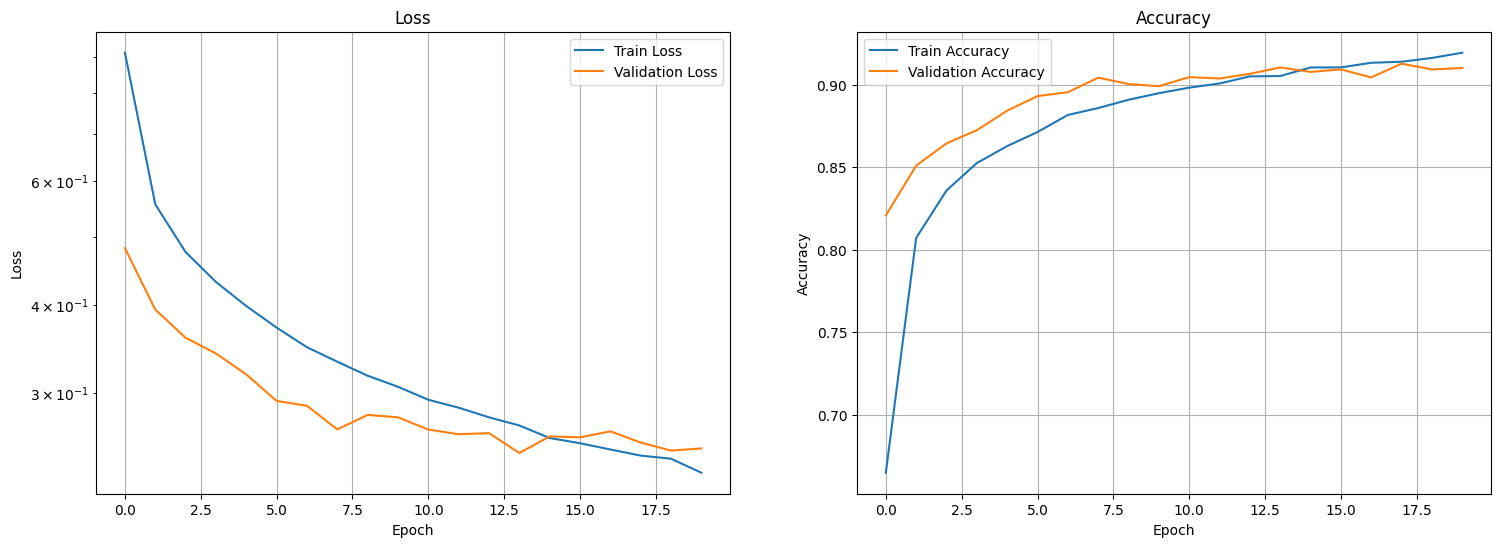

Epoch 20/20, Train Loss: 0.2313, Val Loss: 0.2504


In [71]:
for epoch in range(epochs):
    train_loss = run(model, trainloader, loss_func, optimizer)
    val_loss = run(model, valloader, loss_func)
    
    train_losses.append(train_loss[0])
    val_losses.append(val_loss[0])
    train_accuracy.append(train_loss[1])
    val_accuracy.append(val_loss[1])

    show_losses(train_losses, val_losses, train_accuracy, val_accuracy)
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss[0]:.4f}, Val Loss: {val_loss[0]:.4f}')

In [72]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
              ReLU-2           [-1, 64, 28, 28]               0
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          36,928
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 128]         401,536
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 64]           8,256
             ReLU-12                   [-1, 64]               0
          Dropout-13                   [-1, 64]               0
           Linear-14                   

In [73]:
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_cm = run(model, testloader, loss_func)
val_loss, val_accuracy, val_precision, val_recall, val_f1, val_cm = run(model, valloader, loss_func)

In [74]:
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')
print('Validation Confusion Matrix:')
print(val_cm)

Validation Accuracy: 0.9100
Validation Precision: 0.9096
Validation Recall: 0.9100
Validation F1 Score: 0.9091
Validation Confusion Matrix:
[[562   1  17  16   0   1  33   0   2   0]
 [  1 549   1   9   1   0   1   0   0   0]
 [  9   0 551   6  33   0  21   0   1   0]
 [  7   3   2 562   8   0  10   0   1   0]
 [  1   1  35  32 490   0  34   0   1   0]
 [  0   0   1   0   0 559   1  17   0   3]
 [ 86   1  43  15  33   0 415   0   3   0]
 [  0   0   0   0   0   5   0 602   0  12]
 [  1   0   1   1   0   0   3   0 613   0]
 [  0   0   0   0   0   2   1  23   0 557]]


In [75]:
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')
print('Test Confusion Matrix:')
print(test_cm)

Test Accuracy: 0.9175
Test Precision: 0.9169
Test Recall: 0.9175
Test F1 Score: 0.9167
Test Confusion Matrix:
[[542   0  11  17   2   0  38   0   3   0]
 [  2 622   1   6   1   0   0   0   1   0]
 [  9   0 543   3  22   0  23   1   2   0]
 [  6   0   2 545   9   0  10   0   1   0]
 [  1   1  26  18 542   0  31   0   2   0]
 [  0   0   0   0   0 576   0  13   0   6]
 [ 76   1  48  24  25   0 395   0   2   0]
 [  0   0   0   0   0   4   0 595   0  12]
 [  1   0   2   2   1   2   4   0 574   0]
 [  0   0   0   0   0   2   0  21   0 571]]


Модель показывает лучшие метрики со skip-connection, но явно заметно влияние аугментации трейновых данных (хуже, чем могло быть, но в задании прописано "добавить", поэтому убирать аугментации не буду). По ощущениям, время обучения немного снизилось. Графики обучения имеют пересечение, да и в целом похоже, что в модели присутствует переобучение.